In [37]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rpy2.robjects as robj
from mrashpen.inference.mrash_wrapR import MrASHR

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

from gradvi.models import elbo_nmeans
from gradvi.priors import Ash
from gradvi.models import LinearModel
from gradvi.inference import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def saveplot(fig, fileprefix, plotdir = '.'):
    for ext in ['pdf', 'png']:
        fl = f"{plotdir}/{fileprefix}.{ext}"
        fig.savefig(fl, bbox_inches = 'tight')
    return

In [2]:
# Simulate data from the linear regression model y = x1*b1 + x2*b2 + e,
# e ~ N(0,1) with b1 = 0.1, b2 = 0.1.

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1) 
    return Znew


'''
get exact same X and y with the same seed as used by Peter.
https://github.com/pcarbo/mr-ash/blob/master/scripts/
'''

# Simulate data from the linear regression model y = x1*b1 + x2*b2 + e,
# e ~ N(0,1) with b1 = 0.1, b2 = 0.1.

n = 1000
p = 2
s2 = 1.0
seed = 1
rho = 0.99

np.random.seed(seed)
iidx = np.random.normal(size = n * p).reshape(n, p)
comr = np.random.normal(size = n).reshape(n, 1)
X    = comr * np.sqrt(rho) + iidx * np.sqrt(1 - rho)
X    = center_and_scale(X)

beta = np.array([1.0, 1.0])
yerr = np.random.normal(0, np.sqrt(s2), size = n)
y    = np.dot(X, beta) + np.array(yerr)

In [6]:
sk2 = np.array([0, 1, 2])
sk  = np.sqrt(sk2)
wk  = np.array([0, 0.8, 0.2])
prior = Ash(sk, wk = wk, scaled = False)

In [7]:
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, s2init = 1, winit = wk, update_pi = False, update_sigma2 = False, maxiter = 8000)
print (mrash_r.coef)

Mr.ASH terminated at iteration 598.
[0.87504427 1.15292424]


In [8]:
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_coef = np.array([0, 0])
mrash_coef_updates = [mrash_coef]
for itr in range(500):
    mrash_r.fit(X, y, sk, s2init = 1, winit = wk, binit = mrash_coef,
                update_pi = False, update_sigma2 = False, maxiter = 1 )
    mrash_coef = mrash_r.coef
    mrash_coef_updates.append(mrash_coef)

Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH terminated at iteration 1.
Mr.ASH termina

In [9]:
gradvi = LinearRegression(obj = 'direct', optimize_s = False, optimize_w = False, get_coef_path = True)
gradvi.fit(X, y, prior, s2_init = s2)

In [10]:
gradvi.niter

5

In [11]:
gradvi.coef_path

[array([0.70652254, 0.70769054]),
 array([1.0123096 , 1.01564925]),
 array([0.99508319, 1.03317453]),
 array([0.87507279, 1.15291353]),
 array([0.87504364, 1.15292486])]

In [12]:
#b_seq = np.linspace(-100., 100., 50)
b1_seq = np.linspace(-0.1, 2.5, 100)
b2_seq = np.linspace(-0.1, 1.5, 100)
b_seq = np.linspace(-0.1, 2.5, 10)
b1, b2 = np.meshgrid(b1_seq, b2_seq)
b_grid = np.stack((b1, b2))

ix = b_grid.shape[1]
iy = b_grid.shape[2]
elbo_grid = np.zeros((ix, iy))
for i in range(ix):
    for j in range(iy):
        b_point = b_grid[:, i, j]
        lm = LinearModel(X, y, b_point, s2, prior, objtype = 'direct')
        elbo_grid[i, j] = lm.objective
        #elbo_grid[i, j] = elbo_nmeans.ash2(X, y, b_point, s2, prior)

In [40]:
b_grid.shape

(2, 100, 100)

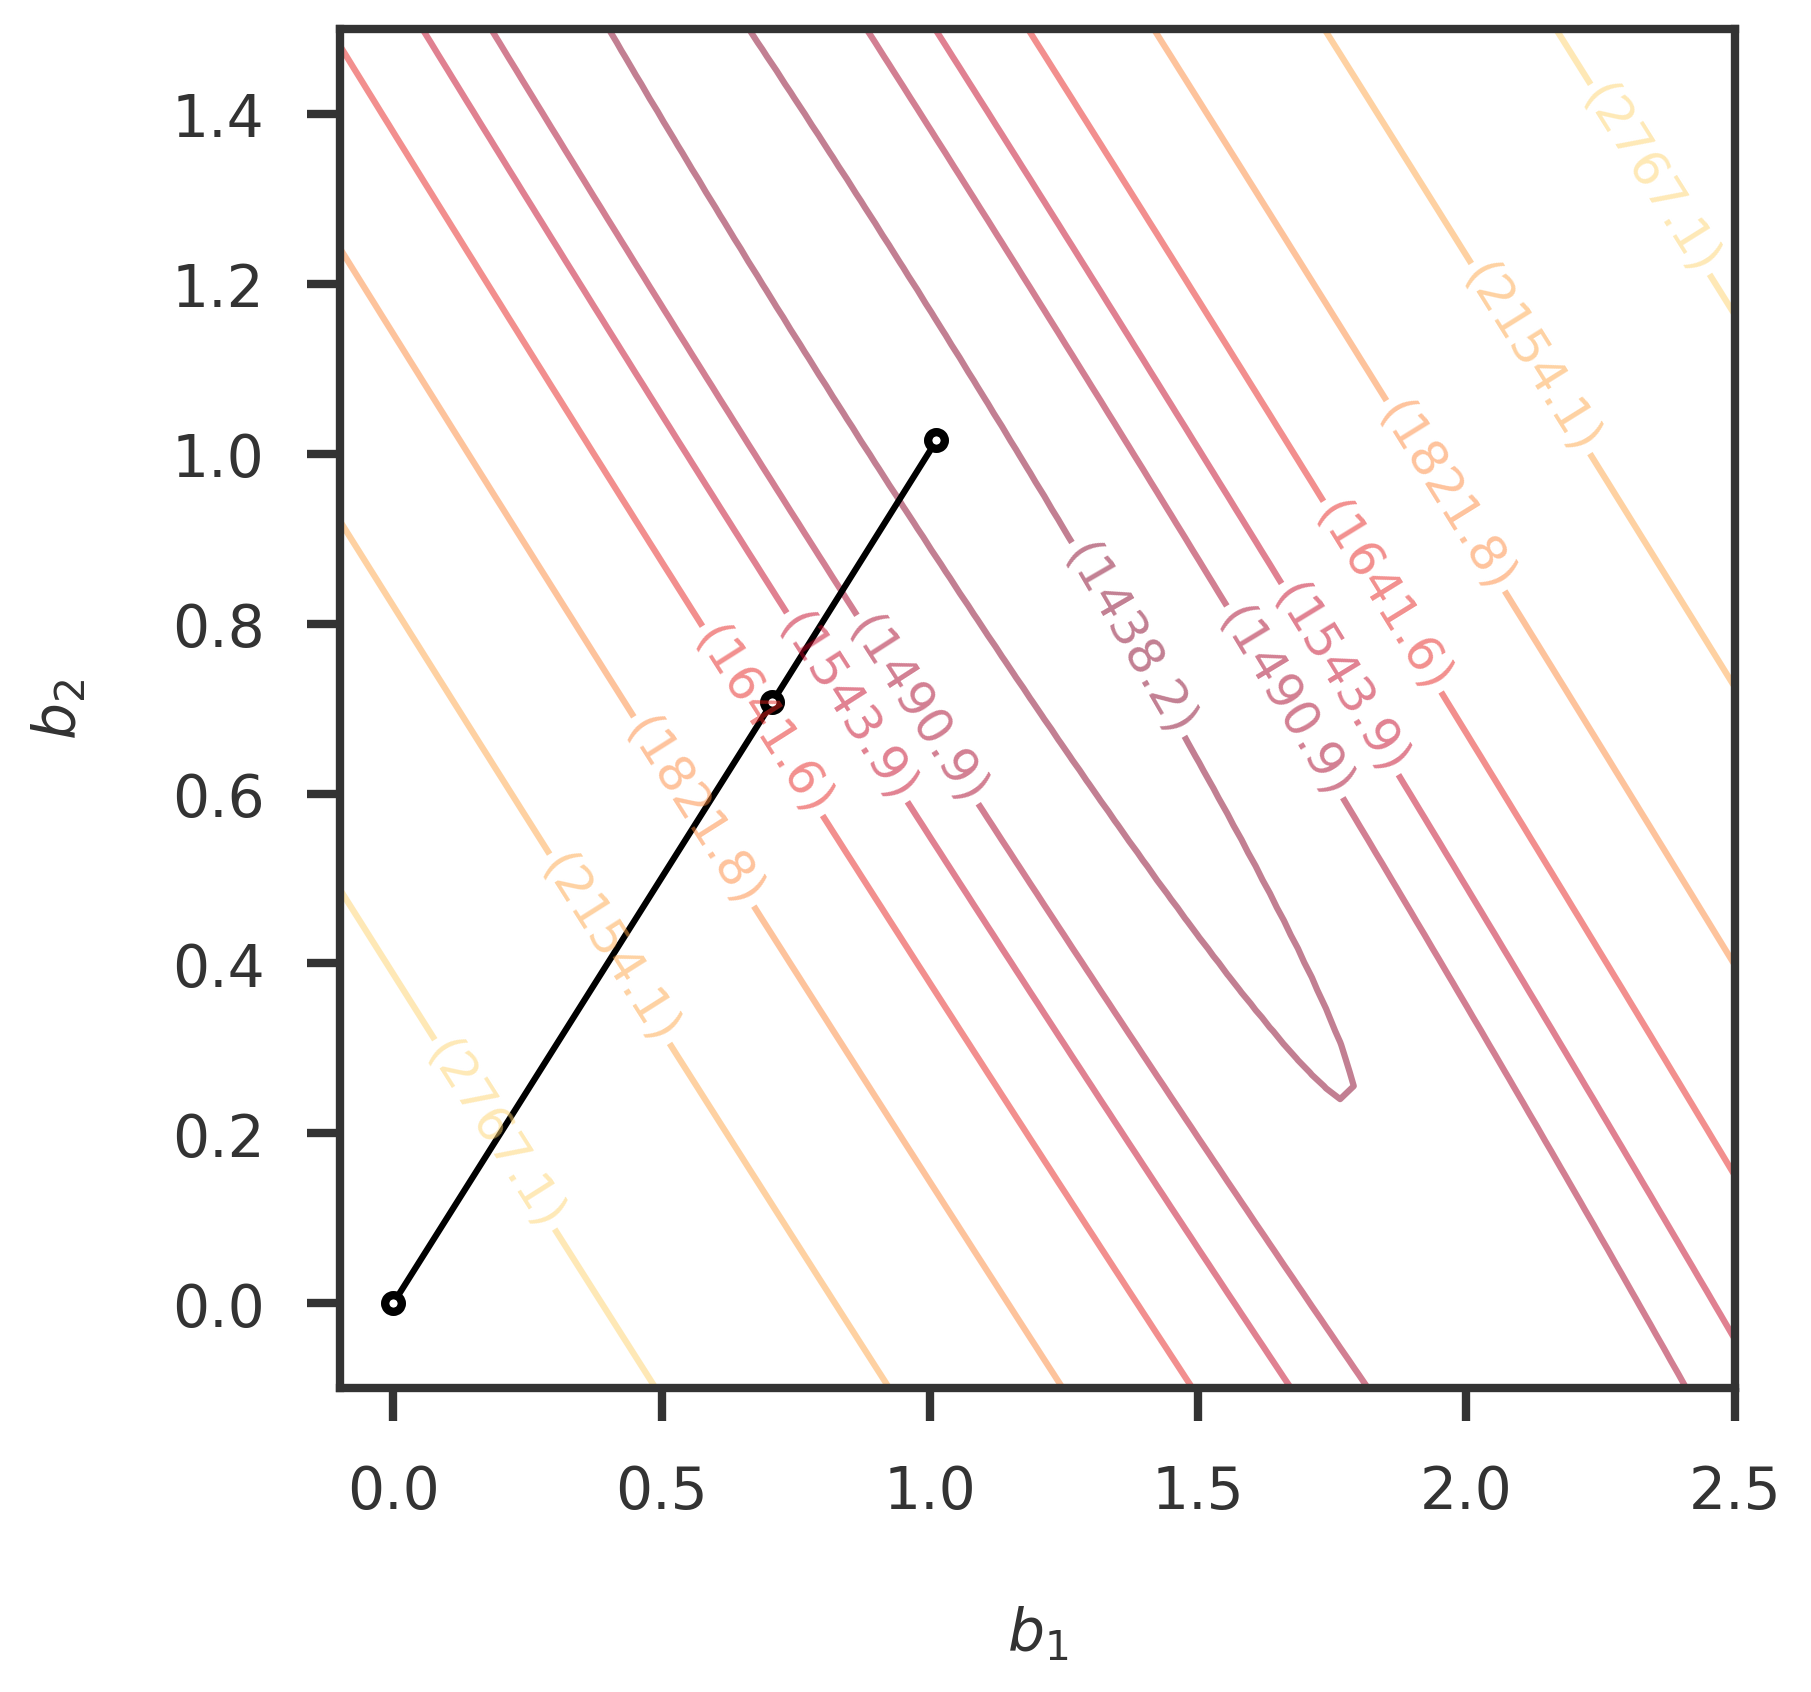

In [88]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)
zmin = np.min(elbo_grid)
zmax = np.max(elbo_grid)
clevels = np.logspace(1, np.log10(zmax - zmin), 10) + zmin

# Manually specify ELBO levels for this plot
clevels_plt = clevels[2:]
clevels_plt[0] = clevels[0]

cmap = cm.YlOrRd_r
norm = cm.colors.TwoSlopeNorm(vmin=zmin, vcenter=zmin + 400, vmax=zmax)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
cs1 = ax1.contour(b_grid[0], b_grid[1], elbo_grid, clevels_plt, cmap = cmap, norm = norm, alpha = 0.5)

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"({s})" if plt.rcParams["text.usetex"] else f"({s})"

ax1.clabel(cs1, cs1.levels, inline = True, fmt = fmt, fontsize = 12)

ax1.set_xlabel(r'$b_1$')
ax1.set_ylabel(r'$b_2$')

# b_itr_x = [x[0] for x in mrash_coef_updates[:100]]
# b_itr_y = [x[1] for x in mrash_coef_updates[:100]]
# fileprefix = '2d_iteration_updates_cavi'

b_itr_x = [0] + [x[0] for x in gradvi.coef_path[:2]]
b_itr_y = [0] + [x[1] for x in gradvi.coef_path[:2]]
fileprefix = '2d_iteration_updates_gradvi'


ax1.plot(b_itr_x, b_itr_y, marker = 'o', markersize = 4, markeredgecolor='black', markerfacecolor = 'white', markeredgewidth = 2,
         ls = 'solid', color = 'black')


saveplot(fig, fileprefix)

plt.show()

In [28]:
clevels

array([1428.15314433, 1702.53667882, 1976.92021332, 2251.30374781,
       2525.68728231, 2800.0708168 , 3074.45435129, 3348.83788579,
       3623.22142028, 3897.60495478])

In [20]:
zmax

3897.604954777588

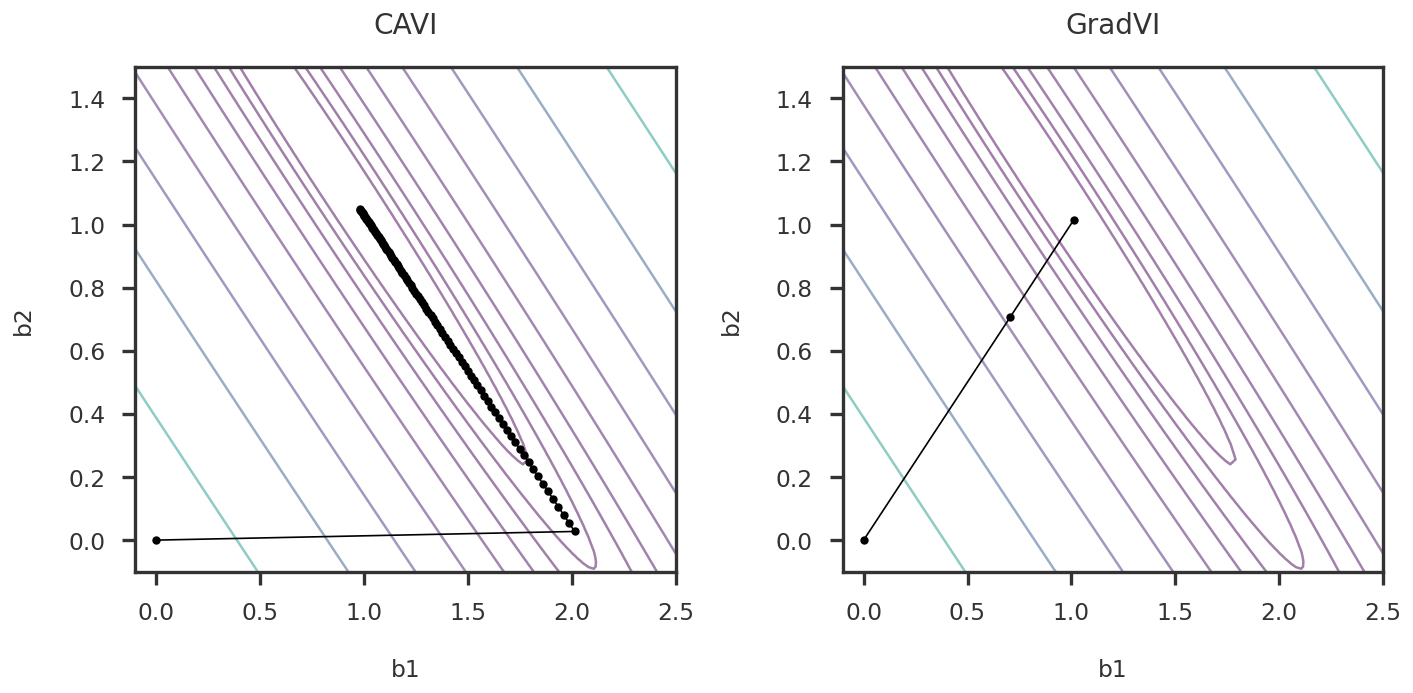

In [27]:
zmin = np.min(elbo_grid) #- 1 * np.std(elbo_grid)
zmax = np.max(elbo_grid) #+ 1 * np.std(elbo_grid)
#clevels = np.logspace(zmin, zmax, 100)
clevels = np.logspace(1, np.log10(zmax - zmin), 10) + zmin
#clevels[0] = clevels[1] - (clevels[1] - zmin) / 200

max_idx = np.unravel_index(np.argmax(elbo_grid, axis = None), elbo_grid.shape)
min_idx = np.unravel_index(np.argmin(elbo_grid, axis = None), elbo_grid.shape)

xx, yy = b_grid
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.contour(xx, yy, elbo_grid, clevels, alpha = 0.5)
ax2.contour(xx, yy, elbo_grid, clevels, alpha = 0.5)
#ax1.scatter(beta[0], beta[1], color = 'k', marker = '+', s = 100, zorder = 100)
#ax2.scatter(beta[0], beta[1], color = 'k', marker = '+', s = 100, zorder = 100)


# CAVI
b_itr_x = [x[0] for x in mrash_coef_updates]
b_itr_y = [x[1] for x in mrash_coef_updates]
ax1.plot(b_itr_x, b_itr_y, marker = 'o', markersize = 4, ls = 'solid', lw = 1, color = 'black')

# GradVI
b_itr_x = [0] + [x[0] for x in gradvi.coef_path[:2]]
b_itr_y = [0] + [x[1] for x in gradvi.coef_path[:2]]
ax2.plot(b_itr_x, b_itr_y, marker = 'o', markersize = 4, ls = 'solid', lw = 1, color = 'black')

ax1.set_title('CAVI', pad = 20)
ax2.set_title('GradVI', pad = 20)
ax1.set_xlabel('b1')
ax1.set_ylabel('b2')

ax2.set_xlabel('b1')
ax2.set_ylabel('b2')

plt.tight_layout()
plt.show()

In [116]:
np.min(elbo_grid)

1428.225608347106